# Chapter 4 - Classification Laboratory

In [40]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import StandardScaler, scale
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report,\
  roc_curve, auc, RocCurveDisplay

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('seaborn-white')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

## The Stock Market Data
We will begin by examining some numerical and graphical summaries of the `Smarket` data, which is part of the `ISLR2` library. This data set consists of percentage returns for the S\&P 500 stock index over $1,250$~days, from the beginning of 2001 until the end of 2005. For each date, we have recorded the percentage returns for each of the five previous trading days, `lagone` through `lagfive`. We have also recorded `volume` (the number of shares traded on the previous day, in billions), `Today` (the percentage return on the date in question)  and `direction` (whether the market was `Up` or `Down` on this date). Our goal is to predict `direction` (a qualitative response) using the other features.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
Smarket = pd.read_csv('/content/drive/MyDrive/NSYSU/00_Statistical_learning/Lab/Data/Smarket.csv')
print(Smarket.shape)
Smarket.head()

(1250, 9)


,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,2001,0.381,-0.192,-2.624,-1.055,5.010,1.1913,0.959,Up
1,2001,0.959,0.381,-0.192,-2.624,-1.055,1.2965,1.032,Up
2,2001,1.032,0.959,0.381,-0.192,-2.624,1.4112,-0.623,Down
3,2001,-0.623,1.032,0.959,0.381,-0.192,1.2760,0.614,Up
4,2001,0.614,-0.623,1.032,0.959,0.381,1.2057,0.213,Up


In [4]:
Smarket.columns

Index(['Year', 'Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume', 'Today',
       'Direction'],
      dtype='object')

In [5]:
Smarket.describe(include='all')

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
count,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.00000,1250.000000,1250.000000,1250
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Up
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,648
mean,2003.016000,0.003834,0.003919,0.001716,0.001636,0.00561,1.478305,0.003138,NaN
std,1.409018,1.136299,1.136280,1.138703,1.138774,1.14755,0.360357,1.136334,NaN
min,2001.000000,-4.922000,-4.922000,-4.922000,-4.922000,-4.92200,0.356070,-4.922000,NaN
25%,2002.000000,-0.639500,-0.639500,-0.640000,-0.640000,-0.64000,1.257400,-0.639500,NaN
50%,2003.000000,0.039000,0.039000,0.038500,0.038500,0.03850,1.422950,0.038500,NaN
75%,2004.000000,0.596750,0.596750,0.596750,0.596750,0.59700,1.641675,0.596750,NaN


In [6]:
Smarket.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1250 entries, 0 to 1249
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Year       1250 non-null   int64  
 1   Lag1       1250 non-null   float64
 2   Lag2       1250 non-null   float64
 3   Lag3       1250 non-null   float64
 4   Lag4       1250 non-null   float64
 5   Lag5       1250 non-null   float64
 6   Volume     1250 non-null   float64
 7   Today      1250 non-null   float64
 8   Direction  1250 non-null   object 
dtypes: float64(7), int64(1), object(1)
memory usage: 151.4 KB


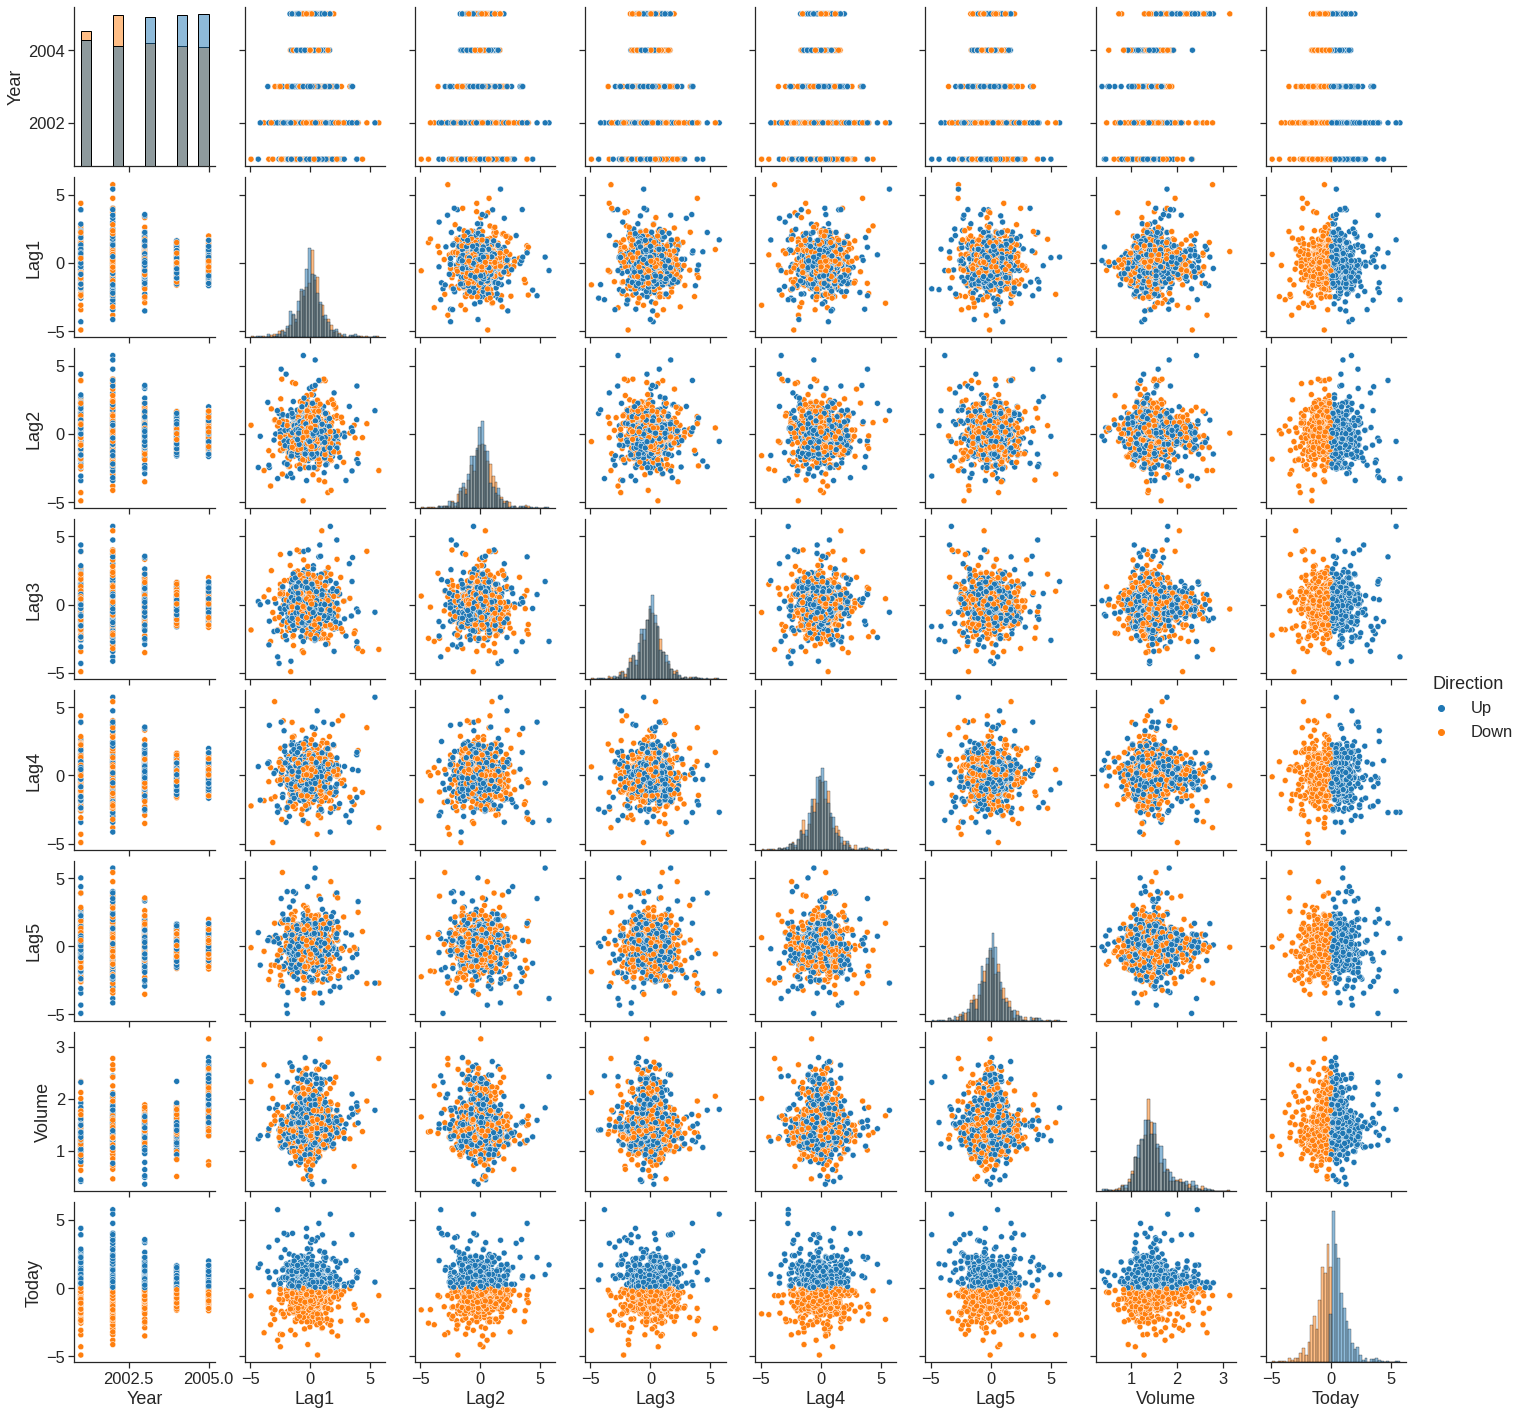

In [7]:
sns.pairplot(data=Smarket, hue='Direction', diag_kind='hist')

The `corr()` function produces a matrix that contains all of the pairwise correlations among the predictors in a data set.

In [8]:
#produces a correlation matrix for all the numrical columns 
corr = Smarket.corr()
corr

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
Year,1.000000,0.029700,0.030596,0.033195,0.035689,0.029788,0.539006,0.030095
Lag1,0.029700,1.000000,-0.026294,-0.010803,-0.002986,-0.005675,0.040910,-0.026155
Lag2,0.030596,-0.026294,1.000000,-0.025897,-0.010854,-0.003558,-0.043383,-0.010250
Lag3,0.033195,-0.010803,-0.025897,1.000000,-0.024051,-0.018808,-0.041824,-0.002448
Lag4,0.035689,-0.002986,-0.010854,-0.024051,1.000000,-0.027084,-0.048414,-0.006900
Lag5,0.029788,-0.005675,-0.003558,-0.018808,-0.027084,1.000000,-0.022002,-0.034860
Volume,0.539006,0.040910,-0.043383,-0.041824,-0.048414,-0.022002,1.000000,0.014592
Today,0.030095,-0.026155,-0.010250,-0.002448,-0.006900,-0.034860,0.014592,1.000000


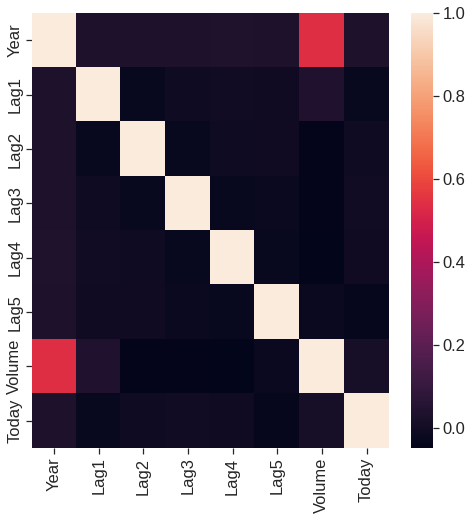

In [9]:
# the best way to visualize corerelations matrices is heatmap
plt.figure(figsize = (8,8))
sns.heatmap(corr)

As one would expect, the correlations between the lag variables and today's returns are close to zero. In other words, there appears to be little correlation between today's returns and previous days' returns. The only substantial correlation is between `Year` and `volume`. By plotting the data, which is ordered chronologically, we see that `volume` is increasing over time. In other words, the average number of shares traded daily increased from 2001 to 2005.

In [10]:
print(corr.iloc[:,-2:])

          Volume     Today
Year    0.539006  0.030095
Lag1    0.040910 -0.026155
Lag2   -0.043383 -0.010250
Lag3   -0.041824 -0.002448
Lag4   -0.048414 -0.006900
Lag5   -0.022002 -0.034860
Volume  1.000000  0.014592
Today   0.014592  1.000000


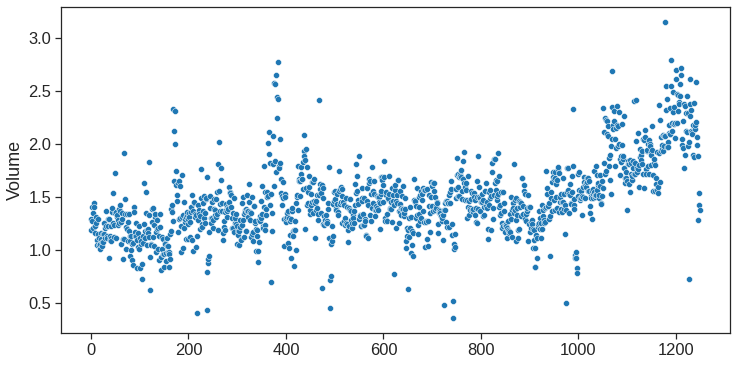

In [11]:
# we choose the x axis as index, chossing year will give a discrete plot
plt.figure(figsize = (12,6))
sns.scatterplot(x=Smarket.index, y="Volume", data=Smarket)

## Logistic Regression

Next, we will fit a logistic regression model in order to predict `direction` using `lagone` through `lagfive` and `volume`. The `glm()` function  can be used to fit many types of generalized linear models , including logistic regression. The syntax of the `glm()` function is similar to that of  `lm()`,  except that we must pass in the argument `families.Binomial` in order to tell `Python` to run a logistic regression rather than some other type of generalized linear model.

In [12]:
pd.concat([pd.get_dummies(Smarket.Direction), Smarket.Direction], axis=1)

,Down,Up,Direction
0,0,1,Up
1,0,1,Up
2,1,0,Down
3,0,1,Up
4,0,1,Up
...,...,...,...
1245,0,1,Up
1246,1,0,Down
1247,0,1,Up
1248,1,0,Down


We choose the encoding to treat Up as 1 and Down as 0

In [13]:
Smarket['Direction2'] = pd.get_dummies(Smarket.Direction, drop_first=True)
Smarket.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction,Direction2
0,2001,0.381,-0.192,-2.624,-1.055,5.010,1.1913,0.959,Up,1
1,2001,0.959,0.381,-0.192,-2.624,-1.055,1.2965,1.032,Up,1
2,2001,1.032,0.959,0.381,-0.192,-2.624,1.4112,-0.623,Down,0
3,2001,-0.623,1.032,0.959,0.381,-0.192,1.2760,0.614,Up,1
4,2001,0.614,-0.623,1.032,0.959,0.381,1.2057,0.213,Up,1


In [14]:
formula = 'Direction2 ~ Lag1+Lag2+Lag3+Lag4+Lag5+Volume'
model = smf.glm(formula=formula, data=Smarket, family=sm.families.Binomial())
result = model.fit()
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             Direction2   No. Observations:                 1250
Model:                            GLM   Df Residuals:                     1243
Model Family:                Binomial   Df Model:                            6
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -863.79
Date:                Sun, 17 Oct 2021   Deviance:                       1727.6
Time:                        11:59:39   Pearson chi2:                 1.25e+03
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1260      0.241     -0.523      0.6

The smallest $p$-value here is associated with `lagone`. The negative coefficient for this predictor suggests that if the market had a positive return yesterday, then it is less likely to go up today. However, at a value of $0.15$, the $p$-value is still relatively large, and so there is no clear evidence of a real association between `lagone` and `direction`. 

We use the `params` function in order to access just the coefficients for this fitted model. https://www.statsmodels.org/dev/generated/statsmodels.genmod.generalized_linear_model.GLMResults.html

In [15]:
print("Coeffieients")
print(result.params)
print("p-Values")
print(result.pvalues)
print("Dependent variables")
print(result.model.endog_names)

Coeffieients
Intercept   -0.126000
Lag1        -0.073074
Lag2        -0.042301
Lag3         0.011085
Lag4         0.009359
Lag5         0.010313
Volume       0.135441
dtype: float64
p-Values
Intercept    0.600700
Lag1         0.145232
Lag2         0.398352
Lag3         0.824334
Lag4         0.851445
Lag5         0.834998
Volume       0.392404
dtype: float64
Dependent variables
Direction2


The `predict()` function can be used to predict the probability that the market will go up, given values of the predictors. If no data set is supplied to the `predict()` function, then  the probabilities are computed for the training data that was used to fit the logistic regression model. Here we have printed only the first ten probabilities. We know that these values correspond to the probability of the market going up, rather than down, because we have set the dummy variable with a 1 for `Up`.

In [16]:
predictions = result.predict()
print(predictions[:10])

[0.50708413 0.48146788 0.48113883 0.51522236 0.51078116 0.50695646
 0.49265087 0.50922916 0.51761353 0.48883778]


In order to make a prediction as to whether the market will go up or down on a particular day, we must convert these predicted probabilities into class labels, `Up` or `Down`. The following command create a vector of class predictions based on whether the predicted probability of a market increase is greater than or less than $0.5$.

In [23]:
predictions_nominal = [ "Up" if x > 0.5 else "Down" for x in predictions]

Given these predictions, the `confusion_matrix()` function can be used to produce a confusion matrix in order to determine how many observations were correctly or incorrectly classified.

In [24]:
cm = confusion_matrix(Smarket.Direction, predictions_nominal)
cm

array([[145, 457],
       [141, 507]])

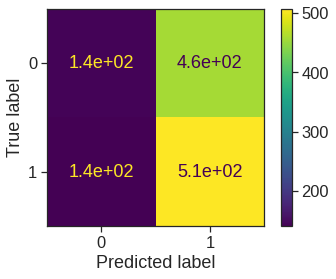

In [31]:
ConfusionMatrixDisplay(cm, display_labels=[0,1]).plot()

In [32]:
print(classification_report(Smarket.Direction, predictions_nominal, digits=3))

              precision    recall  f1-score   support

        Down      0.507     0.241     0.327       602
          Up      0.526     0.782     0.629       648

    accuracy                          0.522      1250
   macro avg      0.516     0.512     0.478      1250
weighted avg      0.517     0.522     0.483      1250



The diagonal elements of the confusion matrix indicate correct predictions, while the off-diagonals represent incorrect predictions. Hence our model correctly predicted that the market would go up on $507$ days and that it would go down on $145$ days, for a total of $507+145 = 652$ correct predictions. The `classification_report()` function can be used to compute the fraction of days for which the prediction was correct. In this case, logistic regression correctly predicted the movement of the market  $52.2$\,\% of the time.

At first glance, it appears that the logistic regression model is working a little better than random guessing. However, this result is misleading because we trained and tested the  model on the same set of $1,250$ observations. In other words,
 $100\%-52.2\%=47.8\%$, is the *training* error rate. As we have seen previously, the training error rate is often overly optimistic---it tends to underestimate the test error rate.  In order to better assess the accuracy of the logistic regression model in this setting, we can fit the model using part of the data, and then examine how well it predicts the *held out* data.
This will yield a more realistic error rate, in the sense that in practice we will be interested in our model's performance not on the data that we used to fit the model, but rather on days in the future for which the market's movements are unknown.

To implement this strategy, we will first create a vector corresponding to the observations from 2001 through 2004. We will then use this vector to create a held out data set of observations from 2005.

In [33]:
train_filter = Smarket.Year < 2005
# train_filter.value_counts()
X_test = Smarket.loc[~train_filter,]
y_test = Smarket.loc[~train_filter, 'Direction2']
y_test.shape

(252,)

The data contains $1{,}250$ elements, corresponding to the observations in our data set. The output above indicates that there are 252 such observations in testset.

We now fit a logistic regression model using only the subset of the observations that correspond to dates before 2005. We then obtain predicted probabilities of the stock market going up for each of the days in our test set---that is, for the days in 2005.

In [34]:
model = smf.glm(formula=formula, data=Smarket, subset=train_filter, family=sm.families.Binomial())
result = model.fit()

Notice that we have trained and tested our model on two completely separate data sets: training was performed using only the dates before 2005, and testing was performed using only the dates in 2005.
Finally, we compute the predictions for 2005 and compare them to the actual movements of the market over that time period.

In [35]:
predictions = result.predict(X_test)
predictions_nominal = [ "Up" if x > 0.5 else "Down" for x in predictions]
print(classification_report(Smarket.loc[~train_filter, 'Direction'], predictions_nominal, digits=3))

              precision    recall  f1-score   support

        Down      0.443     0.694     0.540       111
          Up      0.564     0.312     0.402       141

    accuracy                          0.480       252
   macro avg      0.503     0.503     0.471       252
weighted avg      0.511     0.480     0.463       252



The results are rather disappointing: the test error rate is $52$\,\%, which is worse than random guessing! Of course this result is not all that surprising, given that one would not generally expect to be able to  use previous days' returns to predict future market performance. (After all, if it were possible to do so, then the authors of this book would be out striking it rich rather than writing a statistics textbook.)

We recall that the logistic regression model had very underwhelming $p$-values associated with all of the predictors, and that the smallest $p$-value, though not very small, corresponded to `lagone`. Perhaps by removing the variables that appear not  to be helpful in predicting `direction`, we can obtain a more effective model. After all, using predictors that have no relationship with the response tends to cause a deterioration in the test error rate (since such predictors cause an increase in variance without a corresponding decrease in bias), and so removing such predictors may in turn yield an improvement.

Below we have refit the logistic regression using just `lagone` and `lagtwo`, which seemed to have the highest predictive power in the original logistic regression model.

In [36]:
logreg_stats = smf.glm(formula = 'Direction2 ~ Lag1+Lag2', data=Smarket, subset=train_filter, 
                       family=sm.families.Binomial()).fit()
print(logreg_stats.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             Direction2   No. Observations:                  998
Model:                            GLM   Df Residuals:                      995
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -690.70
Date:                Sun, 17 Oct 2021   Deviance:                       1381.4
Time:                        12:13:41   Pearson chi2:                     998.
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0322      0.063      0.508      0.6

In [37]:
X_test = Smarket.loc[~train_filter, ['Lag1', 'Lag2']]
y_test_pred = logreg_stats.predict(X_test)
y_test_pred_class = [1 if prob > 0.5 else 0 for prob in y_test_pred]
conf_mat = confusion_matrix(y_test, y_test_pred_class)
print(conf_mat)

[[ 35  76]
 [ 35 106]]


In [38]:
TP = conf_mat[1,1]
TN = conf_mat[0,0]
FP = conf_mat[0,1]
FN = conf_mat[1,0]

# print("Accuracy: ", conf_mat.diagonal().sum()/conf_mat.sum() )
print("Accuracy: ", (TP+TN) / (TP+TN+FP+FN) )
print("Sensitivity: ",  TP / (FN + TP) )
print("Precision: ",  TP / (FP + TP) )
print("False Positive Rate: ",  FP / (FP + TN) )

Accuracy:  0.5595238095238095
Sensitivity:  0.75177304964539
Precision:  0.5824175824175825
False Positive Rate:  0.6846846846846847


You can find many useful metrics in the sklearn module https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics

[0.         0.68468468 1.        ] [0.         0.75177305 1.        ]


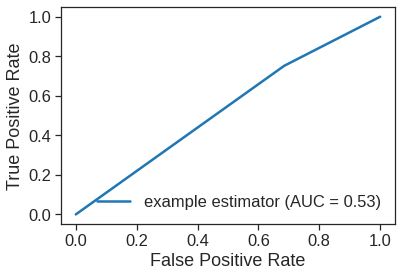

In [45]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_class)
print(fpr, tpr)
roc_auc = auc(fpr, tpr)
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='example estimator').plot()

Now the results appear to be a little better: $56\%$ of the daily movements have been correctly predicted. It is worth noting that in this case, a much simpler strategy of predicting that the market will increase every day will also be correct $56\%$ of the time! Hence, in terms of overall error rate, the logistic regression method is no better than the naive approach. However, the confusion matrix shows that on days when logistic regression predicts an increase in the market, it has a $58\%$ accuracy rate. This suggests a possible trading strategy of buying on days when the model predicts an increasing market, and avoiding trades on days when a decrease is predicted. Of course one would need to investigate more carefully whether this small improvement was real or just due to random chance.

Suppose that we want to predict the returns associated with particular values of `lagone` and `lagtwo`. In particular, we want to predict `direction` on a day when `lagone` and `lagtwo` equal 1.2 and~1.1, respectively, and  on a day when they equal  1.5 and $-$0.8.
We do this using the `predict()` function.

In [ ]:
Up_Prob = logreg_stats.predict(pd.DataFrame([[1.2, 1.1], [1.5, -0.8]], 
                                  columns=["Lag1", "Lag2"]))   # 0 is the 'Up' , 1 is the 'Down'
print("Up probabilities for the 2 samples are %s and %s" % (Up_Prob[0], 
                                                         Up_Prob[1]))

Up probabilities for the 2 samples are 0.47914623911039295 and 0.4960938729355764


## Linear Discriminant Analysis

Now we will perform LDA on the `Smarket` data. In `Python`, we fit an LDA model using the  `LDA()` function, which is part of the `sklearn` library. We fit the model using only the observations before 2005.

In [46]:
X_train = Smarket.loc[train_filter, ['Lag1','Lag2']]
y_train = Smarket.loc[train_filter, 'Direction2']

X_test = Smarket.loc[~train_filter, ['Lag1','Lag2']]
y_test = Smarket.loc[~train_filter, 'Direction2']

lda = LDA()
model = lda.fit(X_train, y_train)

In [47]:
print('Prior Probs are - ',lda.priors_)
print('Class Means are  - ',lda.means_)
print('Coeff are - ', lda.scalings_) # coefficients of ld

Prior Probs are -  [0.49198397 0.50801603]
Class Means are  -  [[ 0.04279022  0.03389409]
 [-0.03954635 -0.03132544]]
Coeff are -  [[-0.64201904]
 [-0.51352928]]


Text(0.5, 15.439999999999998, 'Up')

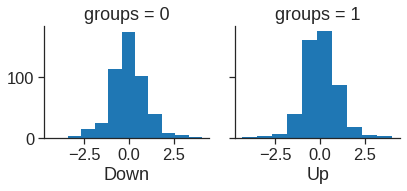

In [48]:
# for plotting lda
ld_sc = X_train.iloc[:, 0] * lda.scalings_[0] + X_train.iloc[:, 1] * lda.scalings_[1]

ld = pd.DataFrame({'groups': y_train, 'ld': ld_sc})

g = sns.FacetGrid(ld, col='groups')
g.map(plt.hist, 'ld')
ax1, ax2 = g.axes[0]
ax1.set_xlabel("Down")
ax2.set_xlabel("Up")

The LDA output indicates that $\hat\pi_1=0.492$ and $\hat\pi_2=0.508$; in other words, $49.2$\,\% of the training observations correspond to days during which the market went down. It also provides the group means; these are the average of each predictor within each class, and are used by LDA as estimates of $\mu_k$. These suggest that there is a tendency for the previous 2~days' returns to be negative on days when the market increases, and a tendency for the previous days' returns to be positive on days when the market declines.

The *coefficients of linear discriminants* output provides the linear combination of `lagone` and `lagtwo` that are used to form the LDA decision rule. In other words, these are the multipliers of the elements of $X=x$ in (4.24).  If $-0.642\times `lagone` - 0.514 \times `lagtwo`$ is large, then the LDA classifier will predict a market increase, and if it is small, then the LDA classifier will predict a market decline.

The above plot produces plots of the *linear discriminants*, obtained by computing $-0.642\times `lagone` - 0.514 \times `lagtwo`$ for each of the training observations. The `Up` and `Down` observations are displayed separately.

The `predict()` function returns LDA's predictions about the movement of the market. The `predict_proba` returns a matrix whose $k$th column contains the posterior probability that the corresponding observation belongs to the $k$th class, computed from (4.15).

In [49]:
pred = lda.predict(X_test)
post = lda.predict_proba(X_test)

The first element, `pred`,  contains LDA's predictions about the movement of the market. The second element, `post`, is a matrix whose $k$th column contains the posterior probability that the corresponding observation belongs to the $k$th class, computed from (4.15).

As we observed in Section 4.5, the LDA and logistic regression predictions are almost identical.

In [50]:
cm = confusion_matrix(y_test,pred)
print(cm)

[[ 35  76]
 [ 35 106]]


Applying a $50$\,\% threshold to the posterior probabilities allows us to recreate the predictions contained in `pred`.

In [51]:
np.unique(post[:,0]>0.5, return_counts=True)

(array([False,  True]), array([182,  70]))

Notice that the posterior probability output by the model corresponds to the probability that the market will *increase*:

In [52]:
post[:20, 0], pred[:20]

(array([0.49017925, 0.4792185 , 0.46681848, 0.47400107, 0.49278766,
        0.49385615, 0.49510156, 0.4872861 , 0.49070135, 0.48440262,
        0.49069628, 0.51199885, 0.48951523, 0.47067612, 0.47445929,
        0.47995834, 0.49357753, 0.50308938, 0.49788061, 0.48863309]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1],
       dtype=uint8))

If we wanted to use a posterior probability threshold other than $50$\,\% in order to make predictions, then we could easily do so. For instance, suppose that we wish to predict a market decrease only if we are very certain that the market will indeed decrease on that day---say, if the posterior probability
is at least $90$\,\%.

In [53]:
np.unique(post[:,0]>0.9, return_counts=True)

(array([False]), array([252]))

No days in 2005 meet that threshold! In fact, the greatest posterior probability of decrease in all of 2005 was $52.02$\,\%.

## Quadratic Discriminant Analysis

We will now fit a QDA model to the `Smarket` data.

In [54]:
qda = QDA()
qda.fit(X_train,y_train)

QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
                              store_covariance=False, tol=0.0001)

In [55]:
print('Mean for class 0 is - ',qda.means_[0])
print('Mean for class 1 is - ',qda.means_[1])
print('Prior probalbilities - ',qda.priors_)

Mean for class 0 is -  [0.04279022 0.03389409]
Mean for class 1 is -  [-0.03954635 -0.03132544]
Prior probalbilities -  [0.49198397 0.50801603]


The output  contains the group means. But it does not contain the coefficients of the linear discriminants, because the QDA classifier involves  a quadratic, rather than a linear, function of the predictors. The `predict()` function works in exactly the same fashion as for LDA.

In [56]:
pred = qda.predict(X_test)
cm = confusion_matrix(y_test,pred)
print(cm)

[[ 30  81]
 [ 20 121]]


In [57]:
print('Accuracy using QDA is ',accuracy_score(y_test,pred))

Accuracy using QDA is  0.5992063492063492


Interestingly, the QDA predictions are accurate almost $60$\,\% of the time, even though the 2005 data was not used to fit the model. This level of accuracy is quite impressive for stock market data, which is known to be quite hard to model accurately.
This suggests that the quadratic form assumed by QDA may capture the true relationship more accurately than the linear forms assumed by LDA and logistic regression.

However, we recommend evaluating this method's performance on a larger test set before betting that this approach will consistently beat the market!

## Naive Bayes

Next, we fit a naive Bayes model to the `Smarket` data. By default, this implementation of the naive Bayes classifier models each quantitative feature using a Gaussian distribution. However, a kernel density method can also be used to estimate the distributions.

Meaning of `var_smoothing`
https://stackoverflow.com/questions/58046129/can-someone-give-a-good-math-stats-explanation-as-to-what-the-parameter-var-smoo

In [72]:
gnb = GaussianNB(var_smoothing=0)
y_pred = gnb.fit(X_train, y_train)

In [73]:
gnb.class_prior_

array([0.49198397, 0.50801603])

In [74]:
gnb.theta_

array([[ 0.04279022,  0.03389409],
       [-0.03954635, -0.03132544]])

In [75]:
np.sqrt(gnb.sigma_)

array([[1.22619505, 1.23792871],
       [1.23045262, 1.21956089]])

The output contains the estimated mean and standard deviation for each variable in each class. For example, the mean for `lagone` is $0.0428$ for `Direction=Down`, and the standard deviation is $1.226$. We can easily verify this:

In [76]:
print(np.mean(X_train.loc[y_train==0]['Lag1']))
print(np.std(X_train.loc[y_train==0]['Lag1']))

0.04279022403258651
1.2261950464925726


Notice that `R` calulates the standard deviation with `N - 1` as the denominator, and in `Python` as `Numpy` use `N`.
https://stackoverflow.com/questions/20708455/different-results-for-standard-deviation-using-numpy-and-r

The `predict()` function is straightforward.

In [77]:
pred = gnb.predict(X_test)
cm = confusion_matrix(y_test,pred)
print(cm)

[[ 29  82]
 [ 20 121]]


In [78]:
print('Accuracy using gnb is ',accuracy_score(y_test,pred))

Accuracy using gnb is  0.5952380952380952


Naive Bayes performs very well on this data, with accurate predictions over $59.5\%$ of the time. This is slightly worse than QDA, but much better than LDA.

The `predict_prob()` function can generate estimates of the probability that each observation belongs to a particular class.

In [79]:
preds = gnb.predict_proba(Smarket.loc[Smarket.Year==2005,['Lag1', 'Lag2']])
preds[:5]

array([[0.4873288 , 0.5126712 ],
       [0.47623584, 0.52376416],
       [0.46529531, 0.53470469],
       [0.47484469, 0.52515531],
       [0.49020587, 0.50979413]])

## $K$-Nearest Neighbors

We will now perform KNN using the `knn()` function.

In [80]:
knn = KNeighborsClassifier(n_neighbors=1)
pred = knn.fit(X_train, y_train).predict(X_test)

In [81]:
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred, digits=3))

[[43 68]
 [58 83]]
              precision    recall  f1-score   support

           0      0.426     0.387     0.406       111
           1      0.550     0.589     0.568       141

    accuracy                          0.500       252
   macro avg      0.488     0.488     0.487       252
weighted avg      0.495     0.500     0.497       252



The results using $K=1$ are not very good,  since only $50$\,\% of the observations are correctly predicted. Of course, it may be that $K=1$ results in  an overly flexible fit to the data. Below, we repeat the analysis using $K=3$.

In [82]:
knn = KNeighborsClassifier(n_neighbors=3)
pred = knn.fit(X_train, y_train).predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred, digits=3))

[[48 63]
 [55 86]]
              precision    recall  f1-score   support

           0      0.466     0.432     0.449       111
           1      0.577     0.610     0.593       141

    accuracy                          0.532       252
   macro avg      0.522     0.521     0.521       252
weighted avg      0.528     0.532     0.529       252



The results have improved slightly. But increasing $K$ further turns out to provide no further improvements. It appears that for this data, QDA provides the best results of the methods that we have examined so far.

KNN does not perform well on the `Smarket` data but it does often provide impressive results. As an example we will apply the KNN approach to the `Insurance` data set, which is part of the `ISLR2` library. This data set includes $85$ predictors that measure
 demographic characteristics for 5,822 individuals. The response variable is `Purchase`, which indicates whether or not a given individual purchases a caravan insurance policy. In this data set, only $6$\,\% of people purchased caravan insurance.

In [83]:
Caravan = pd.read_csv('/content/drive/MyDrive/NSYSU/00_Statistical_learning/Lab/Data/Caravan.csv')
print(Caravan.shape)
print(Caravan.Purchase.value_counts())
print(Caravan.Purchase.value_counts()[1] / len(Caravan))
# Only around 6% of the people purchased the insurance
Caravan.tail()

(5822, 86)
No     5474
Yes     348
Name: Purchase, dtype: int64
0.05977327378907592


,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,MRELSA,MRELOV,MFALLEEN,MFGEKIND,MFWEKIND,MOPLHOOG,MOPLMIDD,MOPLLAAG,MBERHOOG,MBERZELF,MBERBOER,MBERMIDD,MBERARBG,MBERARBO,MSKA,MSKB1,MSKB2,MSKC,MSKD,MHHUUR,MHKOOP,MAUT1,MAUT2,MAUT0,MZFONDS,MZPART,MINKM30,MINK3045,MINK4575,MINK7512,...,PPERSAUT,PBESAUT,PMOTSCO,PVRAAUT,PAANHANG,PTRACTOR,PWERKT,PBROM,PLEVEN,PPERSONG,PGEZONG,PWAOREG,PBRAND,PZEILPL,PPLEZIER,PFIETS,PINBOED,PBYSTAND,AWAPART,AWABEDR,AWALAND,APERSAUT,ABESAUT,AMOTSCO,AVRAAUT,AAANHANG,ATRACTOR,AWERKT,ABROM,ALEVEN,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND,Purchase
5817,36,1,1,2,8,0,6,1,2,1,2,6,5,3,2,2,5,2,2,0,0,4,1,3,2,3,3,3,0,9,0,5,1,3,5,4,4,3,3,0,...,6,0,4,0,0,0,0,0,3,0,0,0,3,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,2,0,0,0,1,0,0,0,0,0,No
5818,35,1,4,4,8,1,4,1,4,6,0,3,2,2,5,0,0,9,2,1,1,3,3,2,0,4,5,0,0,3,6,6,1,2,6,3,0,9,0,0,...,0,0,0,0,1,0,0,3,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,No
5819,33,1,3,4,8,0,6,0,3,5,1,4,3,3,4,0,1,8,1,0,0,2,3,5,1,1,1,4,4,7,2,4,0,5,8,1,5,3,1,1,...,6,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,Yes
5820,34,1,3,2,8,0,7,0,2,7,2,0,0,4,5,0,2,7,0,2,0,2,4,2,0,0,4,5,0,2,7,5,4,0,9,0,0,5,4,0,...,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,No
5821,33,1,3,3,8,0,6,1,2,7,1,2,1,4,4,1,2,6,1,0,1,3,2,4,1,1,2,6,1,5,4,5,2,3,6,3,2,5,2,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,No


Because the KNN classifier predicts the class of a given test observation by identifying the observations that are nearest to it, the scale of the variables matters. Variables that are on a large scale will have a much larger effect on the *distance* between the observations, and hence on the KNN classifier, than variables that are on a small scale. For instance, imagine a data set that contains two variables, `salary` and `age` (measured in dollars and years, respectively). As far as KNN is concerned, a difference of $1,000$ in salary is enormous compared to a difference of $50$ years in age. Consequently, `salary` will drive the KNN classification results, and `age` will have almost no effect. This is contrary to our intuition  that a salary difference of $1,000$ is quite small compared to an age difference of $50$ years.

Furthermore, the importance of scale to the KNN classifier leads to another issue: if we measured `salary` in Japanese yen, or if we measured `age` in minutes, then we'd get quite different classification results from what we get  if these two variables are measured in dollars and years.

A good way to handle this problem is to  the data so that all variables are given a mean of  zero and  a standard deviation of one. Then all variables will be on a comparable scale. The `scale()` function does just this.
 In standardizing the data, we exclude column `Purchase` variable.

In [137]:
# From a sample of means if the observations it can be seen that the variables falls in different ranges
# We want all the variables to have a same range. 
Caravan.mean()[:5]

MOSTYPE     24.253349
MAANTHUI     1.110615
MGEMOMV      2.678805
MGEMLEEF     2.991240
MOSHOOFD     5.773617
dtype: float64

In [84]:
y = Caravan.Purchase
X = Caravan.drop('Purchase', axis=1).astype('float64')
X_scaled = scale(X)
X_scaled.std(axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

Now every column  has a standard deviation of one and a mean of zero.

We now split the observations into a test set, containing the first 1,000 observations, and a training set, containing the remaining observations. We fit a KNN model on the training data using $K=1$, and evaluate its performance on the test data.

In [85]:
X_train = X_scaled[1000:,:]
y_train = y[1000:]

X_test = X_scaled[:1000,:]
y_test = y[:1000]

In [86]:
knn = KNeighborsClassifier(n_neighbors=1)   # K=1
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)   # returns class label 
print("Test set error rate: ", (y_test != y_pred).mean() )    # manual calculatin

Test set error rate:  0.118


The KNN error rate on the 1,000 test observations is just under 12%. At first glance, this may appear to be fairly good. However, since only 6% of customers purchased insurance, we could get the error rate down to 6% by always predicting ${\tt No}$ regardless of the values of the predictors!

Suppose that there is some non-trivial cost to trying to sell insurance to a given individual. For instance, perhaps a salesperson must visit each potential customer. If the company tries to sell insurance to a random selection of customers, then the success rate will be only 6%, which may be far too low given the costs involved. 

Instead, the company would like to try to sell insurance only to customers who are likely to buy it. So the overall error rate is not of interest. Instead, the fraction of individuals that are correctly predicted to buy insurance is of interest.

It turns out that KNN with $K = 1$ does far better than random guessing among the customers that are predicted to buy insurance. 

In [87]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
cm[1,1]/(cm[0,1]+cm[1,1])

[[873  68]
 [ 50   9]]


0.11688311688311688

Among  $77$ such customers, $9$, or $11.7$\,\%, actually do purchase insurance.  This is  double the rate that one would obtain from random guessing.

Using $K=3$, the success rate increases to $20$\,\%, and with $K=5$ the rate is $26.7$\,\%. This is  over four times the rate that results from random guessing. It appears that KNN is finding some real patterns in a difficult data set!

In [88]:
knn = KNeighborsClassifier(n_neighbors=3)   # K=1
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)   # returns class label 
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(cm[1,1]/(cm[0,1]+cm[1,1]))

knn = KNeighborsClassifier(n_neighbors=5)   # K=1
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)   # returns class label 
cm = confusion_matrix(y_test, y_pred)
print(cm)
cm[1,1]/(cm[0,1]+cm[1,1])

[[921  20]
 [ 54   5]]
0.2
[[930  11]
 [ 55   4]]


0.26666666666666666

However, while this strategy is cost-effective, it is worth noting that only 15 customers are predicted to purchase insurance using KNN with $K=5$. In practice, the insurance company may wish to expend resources on convincing more than just 15 potential customers to buy insurance.

As a comparison, we can also fit a logistic regression model to the data. If we use $0.5$ as the predicted probability cut-off for the classifier, then we have a problem: only seven of the test observations are predicted to purchase insurance. Even worse, we are wrong about all of these!
 However, we are not required to use a cut-off of  $0.5$. If we instead predict a purchase any time the predicted probability of purchase exceeds  $0.25$, we get much better results: we predict that 33 people will purchase insurance, and  we are correct for about $33$\,\% of these people. This is  over five times better than random guessing!

In [89]:
log_reg = LogisticRegression(solver='newton-cg', C=1e9)
log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)  # returns class labels based on threshold=0.5
cm = confusion_matrix(y_test, y_pred)
print(cm)
TP = cm[1,1]
TN = cm[0,0]
FP = cm[0,1]
FN = cm[1,0]
print("Accuracy: ", (TP+TN) / (TP+TN+FP+FN) )
print("Sensitivity(Recall): ",  TP / (FN + TP) )
print("Precision: ",  TP / (FP + TP) )
print("False Positive Rate: ",  FP / (FP + TN) )

[[934   7]
 [ 59   0]]
Accuracy:  0.934
Sensitivity(Recall):  0.0
Precision:  0.0
False Positive Rate:  0.007438894792773645


In [90]:
y_pred_prob = log_reg.predict_proba(X_test)   # returns prob of class labels
y_pred_sensitized = ['Yes' if prob>0.25 else 'No' for prob in y_pred_prob[:,1]]

In [91]:
cm = confusion_matrix(y_test, y_pred_sensitized)
print(cm)

TP = cm[1,1]
TN = cm[0,0]
FP = cm[0,1]
FN = cm[1,0]
print("Accuracy: ", (TP+TN) / (TP+TN+FP+FN) )
print("Sensitivity(Recall): ",  TP / (FN + TP) )
print("Precision: ",  TP / (FP + TP) )
print("False Positive Rate: ",  FP / (FP + TN) )

[[919  22]
 [ 48  11]]
Accuracy:  0.93
Sensitivity(Recall):  0.1864406779661017
Precision:  0.3333333333333333
False Positive Rate:  0.023379383634431455


## Poisson Regression

Finally, we fit a  Poisson regression model to the `Bikeshare` data set, which measures the number of bike rentals (`bikers`) per hour in Washington, DC. The data can be found in the `ISLR2` library.

In [92]:
Bikeshare = pd.read_csv('/content/drive/MyDrive/NSYSU/00_Statistical_learning/Lab/Data/Bikeshare.csv', index_col=0)
Bikeshare.index = Bikeshare.index - 1 
print(Bikeshare.shape)
print(Bikeshare.columns)
# Only around 6% of the people purchased the insurance
Bikeshare.tail()

(8645, 15)
Index(['season', 'mnth', 'day', 'hr', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'casual',
       'registered', 'bikers'],
      dtype='object')


,season,mnth,day,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,bikers
8640,1,Dec,365,19,0,6,0,clear,0.42,0.4242,0.54,0.2239,19,73,92
8641,1,Dec,365,20,0,6,0,clear,0.42,0.4242,0.54,0.2239,8,63,71
8642,1,Dec,365,21,0,6,0,clear,0.40,0.4091,0.58,0.1940,2,50,52
8643,1,Dec,365,22,0,6,0,clear,0.38,0.3939,0.62,0.1343,2,36,38
8644,1,Dec,365,23,0,6,0,clear,0.36,0.3788,0.66,0.0000,4,27,31


We begin by fitting a least squares linear regression model to the data.

In [93]:
Bikeshare.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8645 entries, 0 to 8644
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      8645 non-null   int64  
 1   mnth        8645 non-null   object 
 2   day         8645 non-null   int64  
 3   hr          8645 non-null   int64  
 4   holiday     8645 non-null   int64  
 5   weekday     8645 non-null   int64  
 6   workingday  8645 non-null   int64  
 7   weathersit  8645 non-null   object 
 8   temp        8645 non-null   float64
 9   atemp       8645 non-null   float64
 10  hum         8645 non-null   float64
 11  windspeed   8645 non-null   float64
 12  casual      8645 non-null   int64  
 13  registered  8645 non-null   int64  
 14  bikers      8645 non-null   int64  
dtypes: float64(4), int64(9), object(2)
memory usage: 1.1+ MB


In [94]:
Bikeshare['hr'] = Bikeshare['hr'].astype('category')
Bikeshare['mnth'] = Bikeshare['mnth'].astype('category')
Bikeshare.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8645 entries, 0 to 8644
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   season      8645 non-null   int64   
 1   mnth        8645 non-null   category
 2   day         8645 non-null   int64   
 3   hr          8645 non-null   category
 4   holiday     8645 non-null   int64   
 5   weekday     8645 non-null   int64   
 6   workingday  8645 non-null   int64   
 7   weathersit  8645 non-null   object  
 8   temp        8645 non-null   float64 
 9   atemp       8645 non-null   float64 
 10  hum         8645 non-null   float64 
 11  windspeed   8645 non-null   float64 
 12  casual      8645 non-null   int64   
 13  registered  8645 non-null   int64   
 14  bikers      8645 non-null   int64   
dtypes: category(2), float64(4), int64(8), object(1)
memory usage: 963.7+ KB


In [95]:
print(Bikeshare.mnth)
levels = Bikeshare.mnth.unique()
levels

0       Jan
1       Jan
2       Jan
3       Jan
4       Jan
       ... 
8640    Dec
8641    Dec
8642    Dec
8643    Dec
8644    Dec
Name: mnth, Length: 8645, dtype: category
Categories (12, object): ['April', 'Aug', 'Dec', 'Feb', ..., 'May', 'Nov', 'Oct', 'Sept']


['Jan', 'Feb', 'March', 'April', 'May', ..., 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
Length: 12
Categories (12, object): ['Jan', 'Feb', 'March', 'April', ..., 'Sept', 'Oct', 'Nov', 'Dec']

In [96]:
Bikeshare.mnth.cat.reorder_categories(levels, inplace=True)
Bikeshare.mnth

0       Jan
1       Jan
2       Jan
3       Jan
4       Jan
       ... 
8640    Dec
8641    Dec
8642    Dec
8643    Dec
8644    Dec
Name: mnth, Length: 8645, dtype: category
Categories (12, object): ['Jan', 'Feb', 'March', 'April', ..., 'Sept', 'Oct', 'Nov', 'Dec']

Here, we use Jan and 0 as baseline

In [97]:
# Note double quote is needed fot the reference string!
est = smf.ols('bikers ~ C(mnth, Treatment("Jan")) + C(hr, Treatment(0)) + workingday + temp + weathersit',data = Bikeshare).fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:                 bikers   R-squared:                       0.675
Model:                            OLS   Adj. R-squared:                  0.673
Method:                 Least Squares   F-statistic:                     457.3
Date:                Sun, 17 Oct 2021   Prob (F-statistic):               0.00
Time:                        13:11:56   Log-Likelihood:                -49743.
No. Observations:                8645   AIC:                         9.957e+04
Df Residuals:                    8605   BIC:                         9.985e+04
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

In `ols`, the first level of `hr` (0) and `mnth` (Jan) are treated as the baseline values by specifying the reference and explicity cated to categorical variable. Therefore, no coefficient estimates are provided for them: implicitly, their coefficient estimates are zero, and all other levels are measured relative to these baselines. For example, the Feb coefficient of $6.845$ signifies that, holding all other variables constant, there are on average about 7 more riders in February than in January. Similarly there are about 16.5 more riders in March than in January.

https://github.com/statsmodels/statsmodels/blob/main/examples/python/contrasts.py

The results seen in Section 4.6.1 used a slightly different coding of the variables `hr` and `mnth`, as follows:

In [98]:
from patsy.contrasts import Sum
contrast1 = Sum().code_without_intercept(list(range(24)))
#print(contrast.matrix)
contrast2 = Sum().code_without_intercept(list(range(12)))

In [99]:
est2 = smf.ols('bikers ~ C(mnth, contrast2) + C(hr, contrast1) + workingday + temp + weathersit',data = Bikeshare).fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                 bikers   R-squared:                       0.675
Model:                            OLS   Adj. R-squared:                  0.673
Method:                 Least Squares   F-statistic:                     457.3
Date:                Sun, 17 Oct 2021   Prob (F-statistic):               0.00
Time:                        13:12:10   Log-Likelihood:                -49743.
No. Observations:                8645   AIC:                         9.957e+04
Df Residuals:                    8605   BIC:                         9.985e+04
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

What is the difference between the two codings?  In `est2`,  a coefficient estimate is reported for all but the last level of `hr` and `mnth`. Importantly, in `est2`, the coefficient estimate for the last level of `mnth` is not zero: instead, it equals the *negative of the sum of the coefficient estimates for all of the other levels*. Similarly, in `est2`, the coefficient estimate for the last level of `hr` is the negative of the sum of the coefficient estimates for all of the other levels. This means that the coefficients of `hr` and `mnth` in `est2` will always sum to zero, and can be interpreted as the difference from the mean level. For example, the coefficient for January of $-46.087$ indicates that, holding all other variables constant, there are typically 46 fewer riders in January relative to the yearly average.

It is important to realize that the choice of coding really does not matter, provided that we interpret the model output correctly in light of the coding used. For example, we see that the predictions from the linear model are the same regardless of coding:

In [100]:
np.sum((est.predict() - est2.predict())**2)

1.5405746571538684e-20

The sum of squared differences is zero. We can also see this using the `np.allclose()` function:

In [101]:
np.allclose(est.predict(), est2.predict())

True

To reproduce the left-hand side of Figure 4.13, we must first obtain the coefficient estimates associated with `mnth`. The coefficients for January through November can be obtained directly from the `est2` object. The coefficient for December must be explicitly computed as the negative sum of all the other months.

In [102]:
y1 = list(est2.params[1:12])
y1.append(-np.sum(est2.params[1:12]))

[Text(0, 0, 'J'),
 Text(0, 0, 'F'),
 Text(0, 0, 'M'),
 Text(0, 0, 'A'),
 Text(0, 0, 'M'),
 Text(0, 0, 'J'),
 Text(0, 0, 'J'),
 Text(0, 0, 'A'),
 Text(0, 0, 'S'),
 Text(0, 0, 'O'),
 Text(0, 0, 'N'),
 Text(0, 0, 'D')]

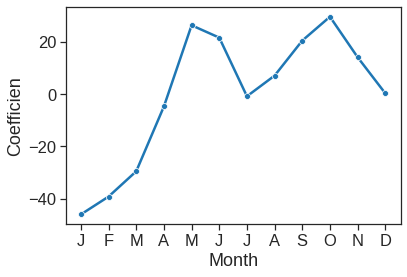

In [103]:
ax = sns.lineplot(x=range(1,13), y=y1, marker="o")
ax.set_xlabel("Month")
ax.set_ylabel("Coefficien")
ax.set_xticks(range(1,13))
ax.set_xticklabels(["J", "F", "M", "A", "M", "J", "J", "A", "S", "O", "N", "D"])

Reproducing the right-hand side of Figure 4.13 follows a similar process.

In [104]:
y2 = list(est2.params[12:35])
y2.append(-np.sum(est2.params[12:35]))

Text(0, 0.5, 'Coefficien')

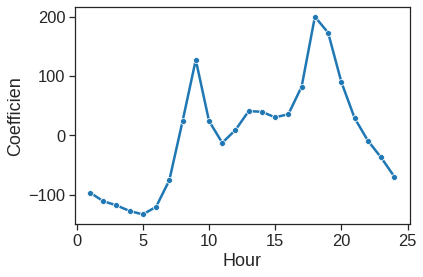

In [105]:
ax = sns.lineplot(x=range(1,25), y=y2, marker="o")
ax.set_xlabel("Hour")
ax.set_ylabel("Coefficien")

Now, we consider instead fitting a Poisson regression model to the `Bikeshare` data. Very little changes, except that we now use the function `glm()` with the argument `families.Poisson` to specify that we wish to  fit a Poisson regression model:

In [106]:
formula = 'bikers ~ C(mnth, contrast2) + C(hr, contrast1) + workingday + temp + weathersit'
model = smf.glm(formula=formula, data=Bikeshare, family=sm.families.Poisson())
result = model.fit()
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 bikers   No. Observations:                 8645
Model:                            GLM   Df Residuals:                     8605
Model Family:                 Poisson   Df Model:                           39
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.4054e+05
Date:                Sun, 17 Oct 2021   Deviance:                   2.2804e+05
Time:                        13:12:21   Pearson chi2:                 2.20e+05
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

We can plot the coefficients associated with `mnth` and `hr`, in order to reproduce Figure 4.15:

In [107]:
y3 = list(result.params[1:12])
y3.append(-np.sum(result.params[1:12]))
y4 = list(result.params[12:35])
y4.append(-np.sum(result.params[12:35]))

[Text(0, 0, 'J'),
 Text(0, 0, 'F'),
 Text(0, 0, 'M'),
 Text(0, 0, 'A'),
 Text(0, 0, 'M'),
 Text(0, 0, 'J'),
 Text(0, 0, 'J'),
 Text(0, 0, 'A'),
 Text(0, 0, 'S'),
 Text(0, 0, 'O'),
 Text(0, 0, 'N'),
 Text(0, 0, 'D')]

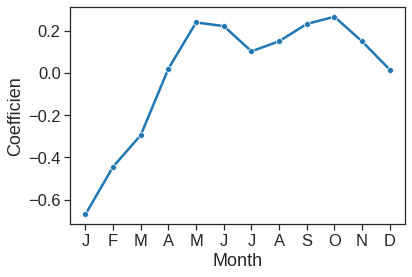

In [108]:
ax = sns.lineplot(x=range(1,13), y=y3, marker="o")
ax.set_xlabel("Month")
ax.set_ylabel("Coefficien")
ax.set_xticks(range(1,13))
ax.set_xticklabels(["J", "F", "M", "A", "M", "J", "J", "A", "S", "O", "N", "D"])

Text(0, 0.5, 'Coefficien')

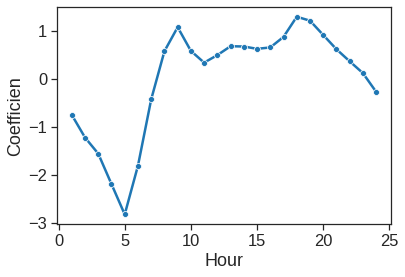

In [109]:
ax = sns.lineplot(x=range(1,25), y=y4, marker="o")
ax.set_xlabel("Hour")
ax.set_ylabel("Coefficien")

We can once again use the `predict()` function to obtain the fitted values (predictions) from this Poisson regression model. 

In [110]:
len(result.predict())

8645

Text(0, 0.5, 'Poisson prediction')

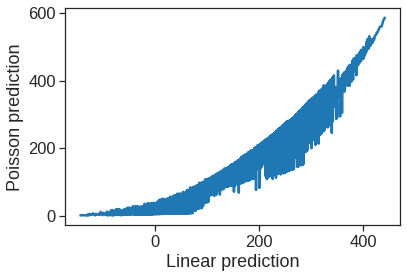

In [111]:
linear_p = est2.predict()
poisson_p = result.predict()
ax = sns.lineplot(x=linear_p, y=poisson_p)
ax.set_xlabel("Linear prediction")
ax.set_ylabel("Poisson prediction")

The predictions from the Poisson regression model are correlated with those from the linear model; however, the former are non-negative. As a result the Poisson regression predictions tend to be larger than those from the linear model for either very low or very high levels of ridership.

In this section, we used the `glm()` function with the argument `families.Poisson` in order to perform Poisson regression. Earlier in this lab we used the `glm()` function with `families.Binomial` to perform logistic regression. Other choices for the `families` argument can be used to fit other types of GLMs. For instance, `families.Gamma` fits a gamma regression model.

## Logistic regression in Sklearn

In [112]:
Smarket['Direction2'] = pd.get_dummies(Smarket.Direction, drop_first=True)
Smarket.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction,Direction2
0,2001,0.381,-0.192,-2.624,-1.055,5.010,1.1913,0.959,Up,1
1,2001,0.959,0.381,-0.192,-2.624,-1.055,1.2965,1.032,Up,1
2,2001,1.032,0.959,0.381,-0.192,-2.624,1.4112,-0.623,Down,0
3,2001,-0.623,1.032,0.959,0.381,-0.192,1.2760,0.614,Up,1
4,2001,0.614,-0.623,1.032,0.959,0.381,1.2057,0.213,Up,1


C is a regularization term where a higher C indicates less penalty on the magnitude of the coefficients and. We set C to be arbitrarily high such that there is effectively no regulariation.

In [118]:
X = Smarket.loc[:, 'Lag1':'Volume']
y = Smarket.Direction2
logreg = LogisticRegression(solver='newton-cg', C=1e42)  #large C for no regularization
logreg.fit(X, y)

LogisticRegression(C=1e+42, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [119]:
print("Intercept:", logreg.intercept_)
list(zip(X.columns, logreg.coef_[0]) )         # coefficients

Intercept: [-0.1259998]


[('Lag1', -0.07307368882753643),
 ('Lag2', -0.04230133955673153),
 ('Lag3', 0.01108516992336594),
 ('Lag4', 0.009358899763344914),
 ('Lag5', 0.010313090846417865),
 ('Volume', 0.1354403650521096)]

In [115]:
list( zip(X.index, logreg.predict_proba(X=X)[:10, 1]) )

[(0, 0.5070841630730092),
 (1, 0.481467927868841),
 (2, 0.4811388544967818),
 (3, 0.5152223784683023),
 (4, 0.510781205065993),
 (5, 0.5069564651153065),
 (6, 0.49265092350090733),
 (7, 0.5092291586044031),
 (8, 0.5176135774773881),
 (9, 0.4888378035325095)]

In [120]:
y_pred_class = logreg.predict(X=X)
y_pred_class.sum()

964

In [121]:
(y == y_pred_class).sum()    

652

In [122]:
print("Accuracy: ", accuracy_score(y, y_pred_class))   # Accuracy
print("Accuracy (manual calculation): %0.7f " % (y == y_pred_class).mean() )

Accuracy:  0.5216
Accuracy (manual calculation): 0.5216000 


In [123]:
logreg.predict([[1.2,1.1,1,1,1,1],
                 [1.5,-0.8,1,1,1,1]])

array([0, 0], dtype=uint8)

## Optional

### Poisson regression with sklearn and column transform
https://scikit-learn.org/stable/auto_examples/linear_model/plot_poisson_regression_non_normal_loss.html

### Yellowbric's plot
https://www.scikit-yb.org/en/latest/api/classifier/index.html#